# Example 8.1: Dyna Maze 
Consider the simple maze shown inset in Figure 8.2. In each of the $47$ states there are four actions, up, down, right, and left, which take the agent deterministically to the corresponding neighboring states, except when movement is blocked by an obstacle or the edge of the maze, in which case the agent remains where it is. Reward is zero on all transitions, except those into the goal state, on which it is $+1$. After reaching the goal state (G), the agent returns to the start state (S) to begin a new episode. This is a discounted, episodic task with $\gamma = 0.95$. 
The main part of Figure 8.2 shows average learning curves from an experiment in which Dyna-Q agents were applied to the maze task. The initial action values were zero, the step-size parameter was $\alpha = 0.1$, and the exploration parameter was $\epsilon = 0.1$. When selecting greedily among actions, ties were broken randomly. The agents varied in the number of planning steps, $n$, they performed per real step. For each $n$, the curves show the number of steps taken by the agent to reach the goal in each episode, averaged over $30$ repetitions of the experiment. After the first episode, performance improved for all values of $n$, but much more rapidly for larger values. Recall that the $n=0$ agent is a nonplanning agent, using only direct reinforcement learning (one-step tabular Q-learning). This was by far the slowest agent on this problem, despite the fact that the parameter values ($\alpha$ and $\epsilon$) were optimized for it. The nonplanning agent took about $25$ episodes to reach ($\epsilon$-)optimal performance, whereas the $n=5$ agent took about five episodes, and the $n=50$ agent took only three episodes.

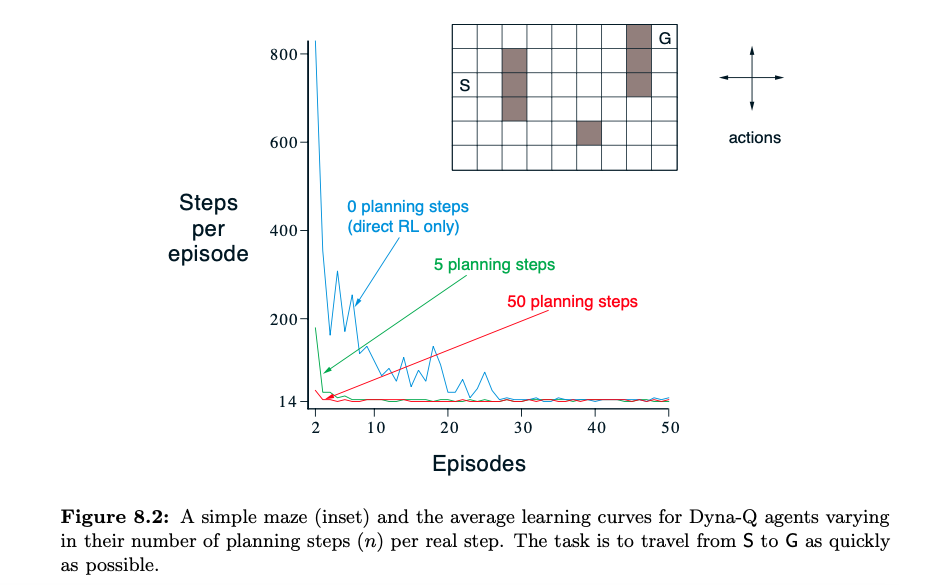

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 
from termcolor import colored
from matplotlib import colors

In [2]:
class Environment:
  def __init__(self, size, startpoint, endpoint, actions, Maze_walls):
    self.m, self.n = size
    self.actions = actions
    self.endpoint = endpoint
    self.startpoint = startpoint
    self.Maze_walls = Maze_walls

  def step(self, position, action):
    if action not in self.actions:
      raise Exception("The action (%s,%s) is not allowed!!" %action)

    reward = 0
    Done = False
    r, c = position
    a, b = action
    new_r, new_c = r-a, c+b

    if ((new_r, new_c) in self.Maze_walls 
        or new_c > self.n-1 
        or new_c < 0 
        or new_r > self.m - 1 
        or new_r < 0):
      return position, 0, False

    if (new_r, new_c) == self.endpoint:
      Done = True
      reward = 1

    return (new_r, new_c), reward, Done


In [3]:
Arrow = {}
Arrow[(0,0)] = '.'
Arrow[(0,-1)] = '\u2190' #Leftwards Arrow
Arrow[(1,0)] = '\u2191' #Upwards Arrow
Arrow[(0,1)] = '\u2192' #Rightwards Arrow
Arrow[(-1,0)] = '\u2193' #Downwards Arrow
Arrow[(1,-1)] = '\u2196' #North West Arrow
Arrow[(1,1)] = '\u2197' #North East Arrow
Arrow[(-1,1)] = '\u2198' #South East Arrow
Arrow[(-1,-1)] = '\u2199' #South West Arrow

In [4]:
class Model():
  def __init__(self, ):
    self.table = {}

  def update(self, s_0, a, s_1, r, Done):
    if s_0 not in self.table.keys():
      self.table[s_0] = {}
      self.table[s_0][a] = (s_1, r, Done)
    else:
      self.table[s_0][a] = (s_1, r, Done)

  def step(self):
    StateList = list(self.table.keys())
    ind = np.random.choice(range(len(StateList)))
    state = StateList[ind]

    ActionList = list(self.table[state].keys())
    ind = np.random.choice(range(len(ActionList)))
    action = ActionList[ind]
    next_state, reward, Done = self.table[state][action]

    return  state, action, next_state, reward, Done

In [5]:
class Maze:
  def __init__(self, Env, Envmodel, n_iters = 100, n_planning_steps = 0,
               gamma = 1, eps = .1, alpha = .1):
    t = time.time()
    self.Type = 'Tabular Dyna-Q'
    self.model = Envmodel
    self.Env = Env
    self.actions = Env.actions
    self.behaiviar_policy = {}
    self.Q = {}
    self.len_episodes_hist = np.zeros(n_iters)
    for x in range(Env.m):
      for y in range(Env.n):
        if (x,y) != Env.endpoint and (x,y) not in self.Env.Maze_walls:
          self.behaiviar_policy[(x,y)] = [1/len(Env.actions) for _ in Env.actions]
          self.Q[(x,y)] = {}
          for action in Env.actions:
            self.Q[(x,y)][action] = 0

    for x in range(1, n_iters+1):  
      state = self.Env.startpoint
      Done = False
      epidose_len = 0
      while not Done:
        action = self.apply_behaiviar_policy(state)
        next_state, reward, Done = self.Env.step(state, action)
        if not Done:
          temp = reward + gamma * max(self.Q[next_state].values())
        else:
          temp = reward
        self.Q[state][action] = self.Q[state][action] + alpha * (temp - self.Q[state][action])
        self.update_behaiviar_policy(eps, state = state)

        self.model.update(state, action, next_state, reward, Done)
        state = next_state

        for j in range(n_planning_steps):
          s_0, a, s_1, r, D = self.model.step()
          if not D:
            temp = r + gamma * max(self.Q[s_1].values())
          else:
            temp = r
          self.Q[s_0][a] = self.Q[s_0][a] + alpha * (temp - self.Q[s_0][a])
          self.update_behaiviar_policy(eps, state = s_0)
        epidose_len += 1
      self.len_episodes_hist[x-1] = epidose_len
                      
    #print(colored('Ended in %s seconds', 'white', 'on_grey') %(time.time() - t))


  def expected_sarsa(self, state):
    P = self.behaiviar_policy[state]
    mu = 0
    for i, a in enumerate(self.actions):
      mu += P[i]*self.Q[state][a]
    return mu

  def apply_behaiviar_policy(self, state):
    probabilities = self.behaiviar_policy[state]
    index = np.random.choice(range(len(self.actions)), p = probabilities)
    next_action = self.actions[index]
    return next_action
        

  def update_behaiviar_policy(self, eps, state = None):
    if state is None:
      States = self.states
    else:
      States = [state]
    for s in States:
      Max = max(self.Q[s].values())
      index = np.random.choice([x for x in range(len(self.actions))
                                if self.Q[s][self.actions[x]] >= Max])
                    
      best_action = self.actions[index]
      for idx in range(len(self.actions)):
        if best_action == self.actions[idx]:
          self.behaiviar_policy[s][idx] = 1 - eps + eps/len(self.actions)
        else:
          self.behaiviar_policy[s][idx] = eps/len(self.actions) 

  def get_optimal_policy(self):
    for state in self.behaiviar_policy.keys():
      idx = np.argmax(self.behaiviar_policy[state])
      self.target_policy[state] = self.actions[idx]

  def bulid_trajectory(self, point):
    Done = False 
    tr = []
    state = point
    while not Done:
      action = self.actions[np.argmax(self.behaiviar_policy[state])]
      tr.append((state, action))
      state, _, Done = Env.step(state, action)
    return tr

  def plot_optimal_policy(self):
    plt.subplots(figsize = (15,15))
    Matrix = np.zeros((self.Env.m, self.Env.n)).astype(int)
    Matrix[self.Env.startpoint] = 1
    Matrix[self.Env.endpoint] = 2
    for pos in self.Env.Maze_walls:
      Matrix[pos] = 3
    trajectory = self.bulid_trajectory(self.Env.startpoint)
    action_trace = {}
    for i, point in enumerate(trajectory):
        action_trace[point[0]] = Arrow[point[1]]
        if point[0] != self.Env.startpoint:
          Matrix[point[0]] = -i-1
    show_annot_array = Matrix < 0
    show_annot_array[self.Env.startpoint] = True
    cmap = colors.ListedColormap(['yellow','green','blue','red' ,'black'])
    bounds=[-100, -0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = sns.heatmap(Matrix, cmap=cmap, annot=True, annot_kws={"size":20},
                      linewidth=0.05, linecolor ='black', xticklabels=False, 
                      yticklabels=False, norm = norm, cbar= False, square = True )
    fig.set_title("Optimal Policy: " + self.Type , fontsize=25)
    for text, position in zip(fig.texts, ((u,v) for u in range(self.Env.m) for v in range(self.Env.n))):
        if self.Env.startpoint == position:
          text.set_text(str(action_trace[position])+'\n Start')
        elif show_annot_array[position] == True:
          text.set_text(str(action_trace[position])+'\n '+ str(np.abs(Matrix[position])))
        elif self.Env.endpoint == position:
          text.set_text('Goal')
          show_annot_array[position] = True

        text.set_visible(show_annot_array[position])
    
    plt.show()
    plt.close()    

### Optimal policy using Dyna-Q  with number of iterations = 5 and number of planning steps = 50

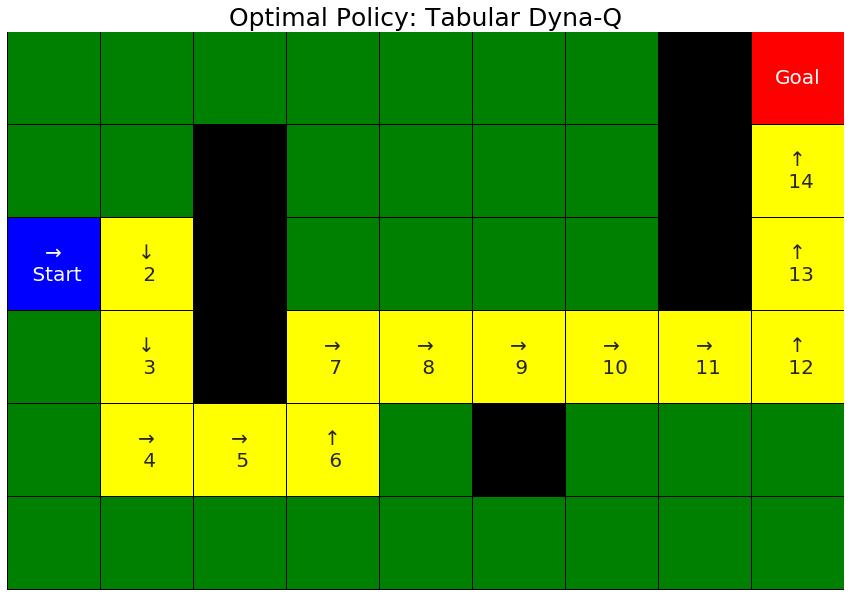

In [6]:
model = Model()
actions=[(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(1,2), (2,2), (3,2), (0,7), (1,7), (2,7), (4,5)]
Env = Environment(size = (6,9), startpoint = (2,0), endpoint = (0,8), 
                 actions = actions, Maze_walls = Maze_walls)
result = Maze(Env = Env, Envmodel = model, eps = .1, gamma= .95, n_iters = 5, n_planning_steps = 50)
result.plot_optimal_policy()

### A simple maze (inset) and the average learning curves for Dyna-Q agents varying in their number of planning steps (n) per real step. The task is to travel from S to G as quickly as possible.

In [7]:
actions=[(0,1), (1,0), (0,-1), (-1,0)]
Maze_walls = [(1,2), (2,2), (3,2), (0,7), (1,7), (2,7), (4,5)]
Env = Environment(size = (6,9), startpoint = (2,0), endpoint = (0,8), 
                  actions = actions, Maze_walls = Maze_walls)
len_episodes_hist_1 = np.zeros(50)
len_episodes_hist_2 = np.zeros(50)
len_episodes_hist_3 = np.zeros(50)
for i in range(30):
    model = Model()
    result_1 = Maze(Env = Env, Envmodel = model, 
                          eps = .1, gamma= .95, n_iters = 50, n_planning_steps = 0)
    len_episodes_hist_1 += result_1.len_episodes_hist
    
    
    model = Model()
    result_2 = Maze(Env = Env, Envmodel = model, 
                          eps = .1, gamma= .95, n_iters = 50, n_planning_steps = 5)
    len_episodes_hist_2 += result_2.len_episodes_hist
    
    
    model = Model()
    result_3 = Maze(Env = Env, Envmodel = model, 
                          eps = .1, gamma= .95, n_iters = 50, n_planning_steps = 50)
    len_episodes_hist_3 += result_3.len_episodes_hist

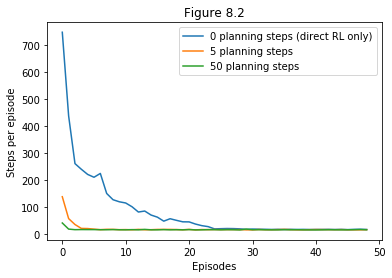

In [8]:
len_episodes_hist_1 /= 30
len_episodes_hist_2 /= 30
len_episodes_hist_3 /= 30

plt.plot(len_episodes_hist_1[1:], label = '0 planning steps (direct RL only)')
plt.plot(len_episodes_hist_2[1:], label = '5 planning steps')
plt.plot(len_episodes_hist_3[1:], label = '50 planning steps')

plt.xlabel('Episodes')
plt.ylabel('Steps per episode')
plt.title('Figure 8.2')
plt.legend()
plt.show() 

# Lets repeat the above experience for Cliff Walking task (Example 6.6)!!

In [9]:
class CliffWalking_Environment:
    def __init__(self, size, startpoint, endpoint, actions, cliff_area):
        self.m, self.n = size
        self.actions = actions
        self.endpoint = endpoint
        self.startpoint = startpoint
        self.cliff_area = cliff_area
        self.Maze_walls = cliff_area

    def step(self, position, action):
        if action not in self.actions:
            raise Exception("The action (%s,%s) is not allowed!!" %action)

        reward = -1
        Done = False
        r, c = position
        a, b = action
        new_r, new_c = r-a, c+b

        if (new_r, new_c) in self.cliff_area:
            return self.startpoint, -100, False

        if (new_c > self.n-1 
            or new_c < 0 
            or new_r > self.m - 1 
            or new_r < 0):
            return position, -1, False  

        if (new_r, new_c) == self.endpoint:
            reward = 0
            Done = True
       
        return (new_r, new_c), reward, Done

In [10]:
actions=[(0,1), (1,0), (0,-1), (-1,0)]
cliff_area = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3,10)]

len_episodes_hist_1 = np.zeros(50)
len_episodes_hist_2 = np.zeros(50)
len_episodes_hist_3 = np.zeros(50)

Env = CliffWalking_Environment(size = (4,12), startpoint = (3,0), endpoint = (3,11), 
                               actions = actions, cliff_area = cliff_area)

for i in range(30):
    model = Model()

    result_1 = Maze(Env = Env, Envmodel = model, 
                    eps = .1, gamma= .95, n_iters = 50, n_planning_steps = 0)
    len_episodes_hist_1 += result_1.len_episodes_hist
    
    
    model = Model()
    result_2 = Maze(Env = Env, Envmodel = model, 
                    eps = .1, gamma= .95, n_iters = 50, n_planning_steps = 5)
    len_episodes_hist_2 += result_2.len_episodes_hist
    
    
    model = Model()
    result_3 = Maze(Env = Env, Envmodel = model, 
                    eps = .1, gamma= .95, n_iters = 50, n_planning_steps = 50)
    len_episodes_hist_3 += result_3.len_episodes_hist


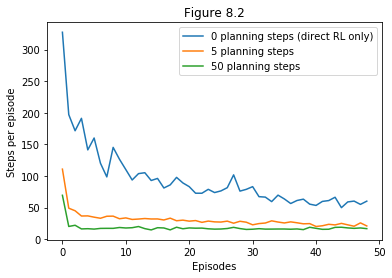

In [11]:
len_episodes_hist_1 /= 30
len_episodes_hist_2 /= 30
len_episodes_hist_3 /= 30

plt.plot(len_episodes_hist_1[1:], label = '0 planning steps (direct RL only)')
plt.plot(len_episodes_hist_2[1:], label = '5 planning steps')
plt.plot(len_episodes_hist_3[1:], label = '50 planning steps')

plt.xlabel('Episodes')
plt.ylabel('Steps per episode')
plt.title('Figure 8.2')
plt.legend()
plt.show() 